In [1]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import os
import h5py

In [2]:
from ret_analysis_functions import * #imports utilities.py file which has functions for plotting psychometrics and other useful things


In [93]:
path = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-3-00/MappingParadigm/27-Nov-2023/"
align_file_name = 'HR-3-00_blue_2023-11-27_000'
file_num = 1
path_azimuth_LR, path_azimuth_RL, path_elevation_UD, path_elevation_DU = retinotopy_analysis.get_data_location(path, file_num)


In [94]:
tensor_azimuthLR = retinotopy_analysis.create_tensor_from_dat(path_azimuth_LR)
tensor_azimuthRL = retinotopy_analysis.create_tensor_from_dat(path_azimuth_RL)
tensor_elevationUD = retinotopy_analysis.create_tensor_from_dat(path_elevation_UD)
tensor_elevationDU = retinotopy_analysis.create_tensor_from_dat(path_elevation_DU)

tensor_azimuthLR.shape, tensor_azimuthRL.shape, tensor_elevationUD.shape, tensor_elevationDU.shape

(torch.Size([905, 300, 300]),
 torch.Size([905, 300, 300]),
 torch.Size([905, 300, 300]),
 torch.Size([905, 300, 300]))

In [95]:
tensor_azimuthLR_align = retinotopy_analysis.extract_aligned_tensor(path, align_file_name, tensor_azimuthLR, file_num)
tensor_azimuthRL_align = retinotopy_analysis.extract_aligned_tensor(path, align_file_name, tensor_azimuthRL, file_num + 1)
tensor_elevationUD_align = retinotopy_analysis.extract_aligned_tensor(path, align_file_name, tensor_elevationUD, file_num + 2)
tensor_elevationDU_align = retinotopy_analysis.extract_aligned_tensor(path, align_file_name, tensor_elevationDU, file_num + 3)

tensor_azimuthLR_align.shape, tensor_azimuthRL_align.shape

Keys: <KeysViewHDF5 ['header', 'sweep_0001']>
Keys: <KeysViewHDF5 ['header', 'sweep_0002']>
Keys: <KeysViewHDF5 ['header', 'sweep_0003']>
Keys: <KeysViewHDF5 ['header', 'sweep_0004']>


(torch.Size([823, 300, 300]), torch.Size([789, 300, 300]))

In [96]:
tensor_azimuth, tensor_elevation = retinotopy_analysis.corrected_az_elev(tensor_azimuthLR_align, tensor_azimuthRL_align, 
                                                                         tensor_elevationUD_align, tensor_elevationDU_align)

In [97]:
corrected_movie_az = retinotopy_analysis.create_stimulus_corrected_movie_pt(tensor_azimuth, 0, 10)
corrected_movie_elev = retinotopy_analysis.create_stimulus_corrected_movie_pt(tensor_elevation, 0, 10)

corrected_movie_elev.shape

torch.Size([480, 300, 300])

In [98]:
phase_map_az = retinotopy_analysis.get_phase_map(corrected_movie_az, 10, 0.043)
phase_map_elev = retinotopy_analysis.get_phase_map(corrected_movie_elev, 10, 0.048)

In [104]:

def phase_power_calc(movie):
    spectrumMovie = np.fft.fft(movie, axis=0)

    #generate power movie
    powerMovie = (np.abs(spectrumMovie) * 2.) / np.size(movie, 0)
    powerMap = np.abs(powerMovie[1,:,:])

    #generate phase movie
    phaseMovie = np.angle(spectrumMovie)
    phaseMap = -1 * phaseMovie[1,:,:]
    phaseMap = phaseMap % (2 * np.pi)
    return powerMap, phaseMap

az_powerMap, az_phaseMap = phase_power_calc(corrected_movie_az)

el_powerMap, el_phaseMap = phase_power_calc(corrected_movie_elev)


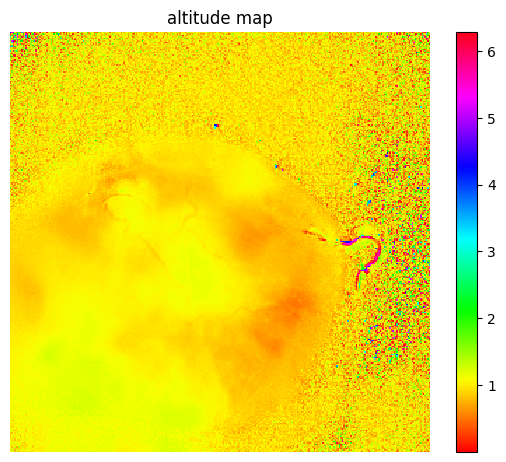

In [105]:
f = plt.figure(figsize=(15, 12))
ax1 = f.add_subplot(221)
fig1 = ax1.imshow(el_phaseMap, cmap='hsv', interpolation='nearest')
ax1.set_axis_off()
ax1.set_title('altitude map')
_ = f.colorbar(fig1)

In [106]:
visual_field_map = retinotopy_analysis.visualSignMap(el_phaseMap, az_phaseMap)

(-0.5, 299.5, 299.5, -0.5)

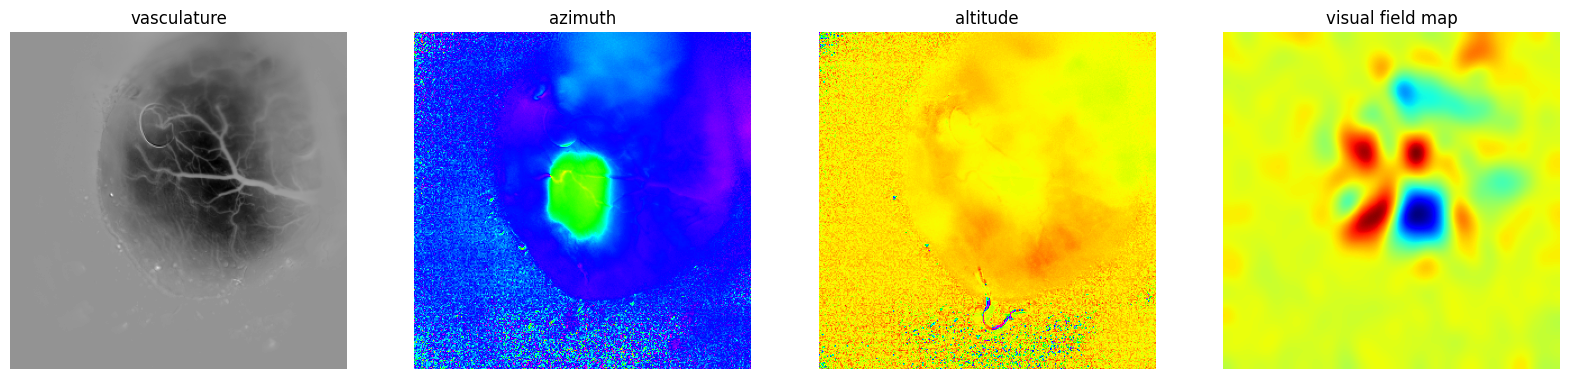

In [107]:
from scipy.ndimage import gaussian_filter

def rotation(image):
    rotated_image = np.rot90(image)
    flipped_image = np.flipud(rotated_image)
    return flipped_image

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs[0].imshow(rotation(tensor_azimuth.mean(axis=0)), cmap="binary")
axs[0].set_title("vasculature")
axs[0].axis('off')

axs[1].imshow(rotation(az_phaseMap), cmap='hsv')
axs[1].set_title("azimuth")
axs[1].axis('off')

axs[2].imshow(rotation(el_phaseMap), cmap='hsv')
axs[2].set_title("altitude")
axs[2].axis('off')

axs[3].imshow(rotation(gaussian_filter(visual_field_map, sigma=std_dev_range)), cmap='jet')
axs[3].set_title("visual field map")
axs[3].axis('off')

(-0.5, 299.5, 299.5, -0.5)

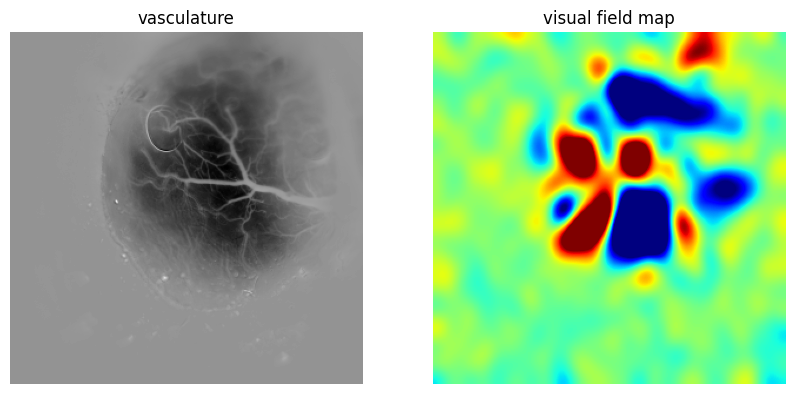

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs[0].imshow(rotation(tensor_azimuth.mean(axis=0)), cmap="binary")
axs[0].set_title("vasculature")
axs[0].axis('off')

axs[1].imshow(rotation(gaussian_filter(visual_field_map, sigma=std_dev_range)), cmap='jet', clim=[-0.15,0.15])
axs[1].set_title("visual field map")
axs[1].axis('off')

(-0.5, 299.5, 299.5, -0.5)

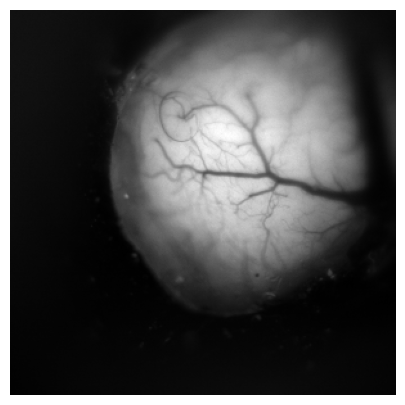

In [111]:
fig, axs = plt.subplots(figsize=(10, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs.imshow(rotation(tensor_azimuthLR[0]), cmap="gist_gray")
axs.axis('off')

(-0.5, 299.5, 299.5, -0.5)

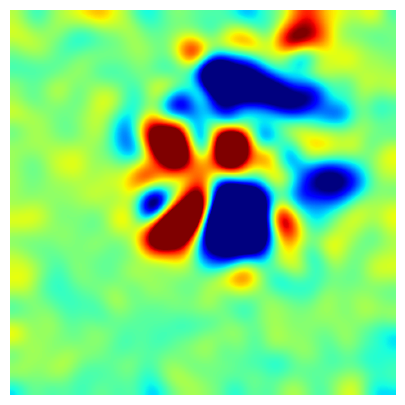

In [112]:
fig, axs = plt.subplots(figsize=(10, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs.imshow(rotation(gaussian_filter(visual_field_map, sigma=mean_std_dev)), cmap='jet', clim=[-0.15,0.15])
axs.axis('off')

In [71]:
def visualSignMap(phasemap1, phasemap2):
    """
    calculate visual sign map from two orthogonally oriented phase maps
    """

    if phasemap1.shape != phasemap2.shape:
        raise LookupError("'phasemap1' and 'phasemap2' should have same size.")

    gradmap1 = np.gradient(phasemap1)
    gradmap2 = np.gradient(phasemap2)

    # gradmap1 = ni.filters.median_filter(gradmap1,100.)
    # gradmap2 = ni.filters.median_filter(gradmap2,100.)

    graddir1 = np.zeros(np.shape(gradmap1[0]))
    # gradmag1 = np.zeros(np.shape(gradmap1[0]))

    graddir2 = np.zeros(np.shape(gradmap2[0]))
    # gradmag2 = np.zeros(np.shape(gradmap2[0]))

    for i in range(phasemap1.shape[0]):
        for j in range(phasemap2.shape[1]):
            graddir1[i, j] = math.atan2(gradmap1[1][i, j], gradmap1[0][i, j])
            graddir2[i, j] = math.atan2(gradmap2[1][i, j], gradmap2[0][i, j])

            # gradmag1[i,j] = np.sqrt((gradmap1[1][i,j]**2)+(gradmap1[0][i,j]**2))
            # gradmag2[i,j] = np.sqrt((gradmap2[1][i,j]**2)+(gradmap2[0][i,j]**2))

    vdiff = np.multiply(np.exp(1j * graddir1), np.exp(-1j * graddir2))

    areamap = np.sin(np.angle(vdiff))

    return areamap

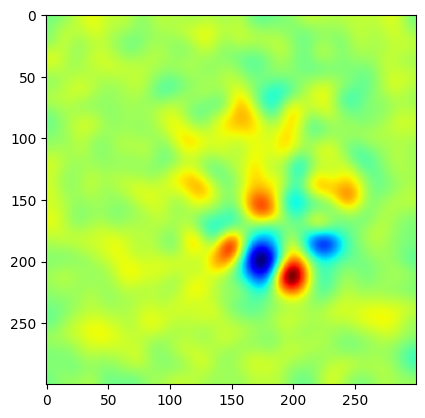

In [72]:
visual_field_map = visualSignMap(phase_map_elev[0], phase_map_az[0])
plt.imshow(rotation(gaussian_filter(visual_field_map, sigma=mean_std_dev)), cmap='jet')

